# Setting up the environment

## Importing required libraries:
Required libraries include:
<ul>
    <li><strong>Numpy</strong> and <strong>Pandas</strong> for data analysis</li>
    <li><strong>Matplotlib</strong> and <strong>Seaborn</strong> for data visualization</li>
</ul>

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Loading the data
<p>
The dataset was acquired from <a href="https://www.kaggle.com/datasets/arashnic/covid19-case-surveillance-public-use-dataset">Kaggle</a> and it contains the data for covid patients in the US.
</p>
<p>
In order to avoid warning about mixed types, the first three columns need to be parsed as datetime during loading.
</p>

In [59]:
df = pd.read_csv("./dataset/covid.csv", parse_dates=[0, 1, 2])

# Data Analysis

## Exploring the dataset
The following section explores the dataset's properties:
<ul>
  <li>Overview of data</li>
  <li>Shape and size</li>
  <li>Features</li>
</ul>

In [60]:
df.head(10)

,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,Race and ethnicity (combined),hosp_yn,icu_yn,death_yn,medcond_yn
0,2020-11-10,2020-11-10,NaT,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,Unknown,No,No
1,2020-11-14,2020-11-10,2020-11-10,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,No
2,2020-11-19,2020-11-10,2020-11-09,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,No
3,2020-11-14,2020-11-10,NaT,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",Missing,Missing,No,Missing
4,2020-11-13,2020-11-10,2020-11-10,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,Yes
5,2020-11-17,2020-11-10,2020-11-08,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",Missing,Missing,Missing,Missing
6,2020-11-14,2020-11-10,NaT,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,Missing,Missing,Missing
7,2020-11-10,2020-11-10,NaT,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",Missing,Missing,Missing,Missing
8,2020-11-10,2020-11-10,NaT,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",Unknown,Unknown,No,Unknown
9,2020-11-17,2020-11-10,NaT,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",Missing,Missing,Missing,Missing


In [61]:
no_of_instances, no_of_features = df.shape
print("The dataset containes %d features and %d instances." %(no_of_features, no_of_instances))

The dataset containes 11 features and 8405079 instances.


In [62]:
df.dtypes

cdc_report_dt                    datetime64[ns]
pos_spec_dt                      datetime64[ns]
onset_dt                         datetime64[ns]
current_status                           object
sex                                      object
age_group                                object
Race and ethnicity (combined)            object
hosp_yn                                  object
icu_yn                                   object
death_yn                                 object
medcond_yn                               object
dtype: object

## Data cleanse

### Splitting the Race/Ethnicity feature into Race and Ethnicity

"Race" and "Ethnicity" are combined together in "Race and ethnicity (combined)" in the format of "Race, Ethnicity";
So, they can be extracted into their own separate features and afterwards, the combined feature can be removed from the data frame:

In [63]:
race_ethnicity_split = df['Race and ethnicity (combined)'].str.split(",",n=1,expand=True)
df["race"] = race_ethnicity_split[0]
df["ethnicity"] = race_ethnicity_split[1]

df = df.drop(["Race and ethnicity (combined)"], axis=1)

### Dropping unused features

"date" features are not used in our model; so the following can be removed from the data frame:
<ul>
  <li>cdc_report_dt</li>
  <li>pos_spec_dt</li>
  <li>ondet_dt</li>
</ul>


In [64]:
df = df.drop(["cdc_report_dt", "pos_spec_dt", "onset_dt"], axis=1)

### Cleaning up the target feature

The target feature "death_yn" will be stating whether the patient has died from COVID or not; however, currently it contains other extra and unclear values as well:

In [65]:
df.death_yn.value_counts()

No         3690813
Missing    3486923
Unknown    1043766
Yes         183577
Name: death_yn, dtype: int64

In order to deal with unclear values, the instances containing "Unknown" and "Missing" for their "death_yn" feature will be removed from the data frame:

In [66]:
df = df[~df['death_yn'].isin(['Unknown', 'Missing'])]

Now the target feature is either "Yes" or "No":

In [67]:
df.death_yn.value_counts()

No     3690813
Yes     183577
Name: death_yn, dtype: int64

### Dealing with missing values

The below counts the number of NULL values in each feature.

In [68]:
df.isnull().sum()

current_status          0
sex                     9
age_group              55
hosp_yn                 0
icu_yn                  0
death_yn                0
medcond_yn              0
race                    5
ethnicity         1757489
dtype: int64


#### ethnicity

"ethnicity" containes mostly missing data, so the approach would be to remove this feature:

In [69]:
df = df.drop(["ethnicity"], axis=1)

#### age_group, race, and sex

As seen below (empty resultset), the instances with missing "age_group" data also contain the instances with missing "sex" and "race".

In [70]:
df[(df["sex"].isnull() | df["race"].isnull()) & (~df["age_group"].isnull())]

,current_status,sex,age_group,hosp_yn,icu_yn,death_yn,medcond_yn,race


 So, the best approach is to completely remove them from the data frame:

In [71]:
df = df[~df['age_group'].isnull()]

Now the data frame does not contain any explicit Null values:

In [72]:
df.isnull().sum()

current_status    0
sex               0
age_group         0
hosp_yn           0
icu_yn            0
death_yn          0
medcond_yn        0
race              0
dtype: int64

### Dealing with unknown or invalid data

#### current_status

This feature is currently in good conditions and does not require further cleaning:

In [73]:
df["current_status"].value_counts()

Laboratory-confirmed case    3665423
Probable Case                 208912
Name: current_status, dtype: int64

#### sex

The correct values for the feature would be "Male", "Female", and "Other".
<br>
As seen below, only a very few of the instances have their "sex" feature unspecified ("Unknown" or "Missing").

In [74]:
df["sex"].value_counts()

Female     2031674
Male       1822491
Unknown      13674
Missing       6387
Other          109
Name: sex, dtype: int64

Neither "Female" nor "Male" values are distinctively dominant enough to be used to replace the unspecified data.
<br>
Also, the total number of instances with unspecified "sex" is so little that it is not logical to assign it to a whole separate category.
<br>
So, the best approach is to remove these instances in order to get a more rebust ML model.

In [75]:
df = df[~df['sex'].isin(['Unknown', 'Missing'])]

This gives us a "sex" feature with all the correct values.
<br>
Note that the category of "Other" contains way too few instances; however, it is good to consider it for possible future updates to the data.

In [76]:
df["sex"].value_counts()

Female    2031674
Male      1822491
Other         109
Name: sex, dtype: int64

#### age_group

As seen below, few (relative to the overall count) of instances have unknown "age_group".

In [77]:
df["age_group"].value_counts()

20 - 29 Years    724752
30 - 39 Years    613972
40 - 49 Years    570532
50 - 59 Years    552881
60 - 69 Years    399846
10 - 19 Years    391442
70 - 79 Years    240715
80+ Years        210326
0 - 9 Years      145803
Unknown            4005
Name: age_group, dtype: int64

On one hand there is not a distinctive mode value in this feature to replace Unknown values with it; and on the other hand it cannot be deduced via other values in the data frame. Also the total number of instances with Unknown age_group values is too few.
<br>
So, the best approach would be remove them from the data frame.

In [78]:
df = df[df['age_group'] != "Unknown"]

The "age_group" feature after removing the Unknown data:

In [79]:
df["age_group"].value_counts()

20 - 29 Years    724752
30 - 39 Years    613972
40 - 49 Years    570532
50 - 59 Years    552881
60 - 69 Years    399846
10 - 19 Years    391442
70 - 79 Years    240715
80+ Years        210326
0 - 9 Years      145803
Name: age_group, dtype: int64

#### hosp_yn

This feature specifies whether the patient has been hospitalized or not.

In [80]:
df["hosp_yn"].value_counts()

No         2681210
Unknown     401225
Missing     387404
Yes         380430
Name: hosp_yn, dtype: int64

As presented below (empty resultset), there are NO INSTANCES where the "hosp_yn" is unspecified and the "icu_yn" is "yes"; hence, the "hosp_yn" cannot be deduced from the "icu_un" feature.

In [81]:
df[(df["icu_yn"] == "Yes") & (df["hosp_yn"].isin(["Unknown", "Missing"]))]

,current_status,sex,age_group,hosp_yn,icu_yn,death_yn,medcond_yn,race


Also, the total number of cases with unspecified hospitalization status is so large that it deserves its own category:

In [82]:
df["hosp_yn"].replace(['Missing', 'Unknown'], "Unspecified", inplace=True)

After the above processins, the "hosp_yn" feature is as below:

In [83]:
df["hosp_yn"].value_counts()

No             2681210
Unspecified     788629
Yes             380430
Name: hosp_yn, dtype: int64

#### icu_yn

As seen below, the majority of instances have this feature as either "Missing" or "Unknown":

In [84]:
df["icu_yn"].value_counts()

Missing    2425643
Unknown     693620
No          684278
Yes          46728
Name: icu_yn, dtype: int64

Since the unclear "icu_yn" data accounts for the majority of instances, it would not be prefarable to remove all those instances; and also it can not be extracted logically from the other instances and features.
<br>
Hence, the "Unknown" and "missing" values can be combined together can considered a whole separate category where the state of being in ICU is unspecified:

In [85]:
df["icu_yn"].replace(['Missing', 'Unknown'], "Unspecified", inplace=True)

Now the "icu_yn" feature is either "Yes", "No", or "Unspecified":

In [86]:
df["icu_yn"].value_counts()

Unspecified    3119263
No              684278
Yes              46728
Name: icu_yn, dtype: int64

#### medcond_yn

In [87]:
df["medcond_yn"].value_counts()

Missing    2345423
No          562943
Yes         557854
Unknown     384049
Name: medcond_yn, dtype: int64

The same as "hosp_yn" and "icu_yn", the unspecified values in this feature are so many that makes them entitled to a separate category

In [88]:
df["medcond_yn"].replace(['Missing', 'Unknown'], "Unspecified", inplace=True)

Which will correct this feature as below:

In [89]:
df["medcond_yn"].value_counts()

Unspecified    2729472
No              562943
Yes             557854
Name: medcond_yn, dtype: int64

#### race

Again, a large portion of the instances have "Unknown" or "Missing" values for "race":

In [90]:
df["race"].value_counts()

White                                     1443410
Unknown                                    987072
Hispanic/Latino                            596787
Black                                      398123
Missing                                    159522
Multiple/Other                             151014
Asian                                       83723
American Indian/Alaska Native               20396
Native Hawaiian/Other Pacific Islander      10222
Name: race, dtype: int64

In order to deal with these unspecified values, a new category of "Unspecified" will be added to the feature's values:

In [91]:
df["race"].replace(['Missing', 'Unknown'], "Unspecified", inplace=True)

So, the new state of the feature "race" would be:

In [92]:
df["race"].value_counts()

White                                     1443410
Unspecified                               1146594
Hispanic/Latino                            596787
Black                                      398123
Multiple/Other                             151014
Asian                                       83723
American Indian/Alaska Native               20396
Native Hawaiian/Other Pacific Islander      10222
Name: race, dtype: int64

### Converting categorial string features into nominal
This step is needed in order to present the correlation matrix

Basically, this step must be done for each of the categorial columns, includin:
<ul>
  <li>current_status</li>
  <li>sex</li>
  <li>age_group</li>
  <li>Race</li>
  <li>hosp_yn</li>
  <li>icu_yn</li>
  <li>death_yn</li>
  <li>medcond_yn</li>
</ul>

<p>In order to shorten the code, a For-loop is run over all the above columns</p>

Before rewriting the values, the classes of the target column are stored to be used later as "labels" for drawing the confusion matrix

In [93]:
target_classes = df["death_yn"].value_counts().index.tolist()
target_classes

['No', 'Yes']

In [94]:
df.dtypes

current_status    object
sex               object
age_group         object
hosp_yn           object
icu_yn            object
death_yn          object
medcond_yn        object
race              object
dtype: object

In [95]:
for col in df.columns:
    df[col] = df[col].astype('category').cat.codes

In [97]:
df.dtypes

current_status    int8
sex               int8
age_group         int8
hosp_yn           int8
icu_yn            int8
death_yn          int8
medcond_yn        int8
race              int8
dtype: object

## Correlation Matrix
The following displays the correlation matrix containing all the numeric variables.

In [101]:
df.corr().style.background_gradient(cmap='coolwarm').format(precision = 2)

,current_status,sex,age_group,hosp_yn,icu_yn,death_yn,medcond_yn,race
current_status,1.00,-0.01,-0.02,-0.04,0.01,0.01,-0.02,0.06
sex,-0.01,1.00,-0.01,0.04,0.01,0.03,-0.00,0.01
age_group,-0.02,-0.01,1.00,0.28,0.04,0.34,0.22,0.08
hosp_yn,-0.04,0.04,0.28,1.00,0.15,0.36,0.12,-0.01
icu_yn,0.01,0.01,0.04,0.15,1.00,0.11,0.03,-0.03
death_yn,0.01,0.03,0.34,0.36,0.11,1.00,0.15,-0.01
medcond_yn,-0.02,-0.00,0.22,0.12,0.03,0.15,1.00,-0.01
race,0.06,0.01,0.08,-0.01,-0.03,-0.01,-0.01,1.00


# Machine Learning
This section implements several Machine Learning algorithms

## Preparations

### Splitting the dataset into Features and Result; and then into Train and Test

In [102]:

x=df.drop(["death_yn"],axis=1)
y=df["death_yn"]

np.random.seed(1)

from sklearn.model_selection import train_test_split, cross_val_score
x_train ,x_test,y_train,y_test = train_test_split(x,y,stratify=y,random_state=12,train_size=0.15,test_size = 0.05)

### Some helper functions to print the measurements, the confusion matrix, and the ROC curve

#### Drawing the confusion matrix

In [103]:
from sklearn.metrics import confusion_matrix

def draw_confusion_matrix(y_test, pred, algorithm):
  cm = confusion_matrix(y_test, pred)

  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

  # labels, title and ticks
  ax.set_xlabel('Predicted values');
  ax.set_ylabel('True values'); 
  ax.set_title('Confusion Matrix for %s' % algorithm); 
  ax.xaxis.set_ticklabels(target_classes);
  ax.yaxis.set_ticklabels(target_classes);

#### Printing metrics

In [104]:
import sklearn.metrics as metrics

def print_metrics(model_name, y_test, y_pred, pred_prob=None):
    print(model_name)
    print('--------------------------------------------------------------------------')
 
    precision_score = metrics.precision_score(y_test, y_pred, average="micro")
    recall_score = metrics.recall_score(y_test, y_pred, average="micro")
    
    accuracy_score  = metrics.accuracy_score(y_test,y_pred)
    print(f'accuracy score :{accuracy_score}') 

    f1_score = metrics.f1_score(y_test,y_pred, average="micro")
    
    classification_report = metrics.classification_report(y_test,y_pred, target_names=target_classes)
    print(classification_report)

#### Drawing the ROC curve

In [105]:
def draw_roc_curve(y_test, y_pred):
  fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
  roc_auc = metrics.auc(fpr, tpr)

  plt.title('Receiver Operating Characteristic Curve')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

## Logistic Regression

Logistic Regression
--------------------------------------------------------------------------
accuracy score :0.9590627175166482
              precision    recall  f1-score   support

          No       0.97      0.99      0.98    183362
         Yes       0.62      0.37      0.46      9152

    accuracy                           0.96    192514
   macro avg       0.79      0.68      0.72    192514
weighted avg       0.95      0.96      0.95    192514



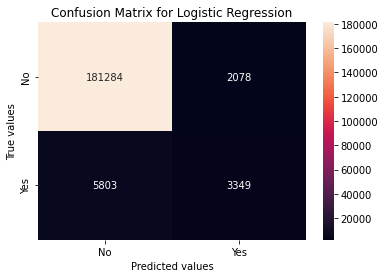

In [106]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(max_iter=1000,random_state=12)
lr_model.fit(x_train,y_train)
pred1 = lr_model.predict(x_test)
prob1 = lr_model.predict_proba(x_test)
draw_confusion_matrix(y_test, pred1, "Logistic Regression")
print_metrics("Logistic Regression", y_test, pred1, prob1[:,-1])